In [64]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from timeit import default_timer as timer

from src_utils import create_action_dataset_v2, compare_trajectories, viz_op_traj_with_attention
from src_utils import get_data_split, create_mask, denormalize, visualize_input
from src_utils import see_steplr_trend, simulate_tgt_actions, plot_attention_weights
from utils import read_cfg_file, save_yaml, load_pkl, print_dict, save_object
from custom_models import mySeq2SeqTransformer_v1
from src_utils import plot_vel_field
import gym
import gym_examples
import sys
import pickle
import wandb
import imageio.v2 as imageio
import time
import argparse
from os.path import join
from datetime import datetime
import numpy as np
from root_path import ROOT
import os
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
OLD_ROOT = "/home/rohit/Documents/Research/Planning_with_transformers/Translation_transformer/my-translat-transformer"
from main import setup_env
from simple_baseline import get_dataset
import matplotlib.pyplot as plt 
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.patches as patches


In [ ]:
#----------------- NOTE ------------------------------
# Change file here and run all cells below 
#  to view results on different scenarios
#-----------------------------------------------

file = 43475 #25305, 43475, 45565
result_path = f'/home/sumanth/rohit/Translation_transformer/my-translat-transformer/tmp/corrected_simple_baseline_{file}_results.pt' 
result_list = torch.load(result_path)
dataset_type = 'DG3'

In [114]:

random_split= True
split_tr_tst_val= [0.8, 0.05, 0.15]
split_ran_seed= 42
dataset_path = '/home/sumanth/rohit/Translation_transformer/my-translat-transformer/data/GPT_dset_DG3/static_obs/GPTdset_DG3_g100x100x120_r5k_Obsv1_w5_1dataset_v2.pkl'
unseen_dataset_path = '/home/sumanth/rohit/Translation_transformer/my-translat-transformer/data/GPT_dset_DG3/static_obs/GPTdset_DG3_g100x100x120_r5k_Obsv1_w5_1dataset_single_43475.pkl'
# unseen_dataset_path = '/home/sumanth/rohit/Translation_transformer/my-translat-transformer/data/GPT_dset_DG3/static_obs/GPTdset_DG3_g100x100x120_r5k_Obsv1_w5_1dataset_single_45565.pkl'
context_len = 120
max_test_samples = 1000
include_obs_diff = True
use_tr_set_for_stats = True

set_split, idx_split = get_dataset(dataset_path, split_tr_tst_val, split_ran_seed, random_split)
train_traj_set, test_traj_set, val_traj_set = set_split
train_idx_set, test_idx_set, val_idx_set = idx_split

# dataset contains optimal actions for different realizations of the env
tr_set = create_action_dataset_v2(train_traj_set, 
                        train_idx_set,
                        context_len, 
                                    )

src_stats = tr_set.get_src_stats()

if dataset_type == "DOLS":
    test_set = create_action_dataset_v2(test_traj_set, 
                            test_idx_set,
                            context_len, 
                            norm_params_4_val = src_stats
                                        )

elif dataset_type == "DG3":
    us_set_split, us_idx_split = get_dataset(unseen_dataset_path, split_tr_tst_val, split_ran_seed, random_split)
    us_train_traj_set, us_test_traj_set, us_val_traj_set = us_set_split
    us_train_idx_set, us_test_idx_set, us_val_idx_set = us_idx_split

    if use_tr_set_for_stats:
        used_test_traj_set = us_train_traj_set
    else:
        used_test_traj_set = us_test_traj_set

    test_set = create_action_dataset_v2(used_test_traj_set, 
                            us_test_idx_set,
                            context_len, 
                            norm_params_4_val = src_stats
                                        )

test_idx = 0
test_timesteps, test_tgt, test_traj_mask, test_target_state, test_env_coef_seq, test_traj_len, test_idx, test_flow_dir, test_rzn = test_set[test_idx]

test_flow_dir = test_flow_dir.replace(OLD_ROOT, ROOT)
test_env = setup_env(test_flow_dir, OLD_ROOT)
test_env.reset()
test_env.set_rzn(test_rzn)

In [115]:
def f(obs_token):

    ru,cl,w = obs_token
    w = w*100
    y_l = 100*(1-ru) + 0.5 + w
    x_l = 100*cl - 0.5
    return x_l, y_l, w

def plot_obstacle(ax, obs_token=None, xyw=None):
    if obs_token != None:
        x_ll, y_ll, w = self.f(obs_token)
    elif xyw != None:
        x_ll, y_ll, w = xyw
    else:
        raise ValueError('provide iether token or xyw')
    rect = patches.Rectangle((x_ll, y_ll), w, w, linewidth=1, edgecolor='k', facecolor='grey', zorder=50000)
    ax.add_patch(rect)
    return

def visualize_output(preds_list, 
                        path_lens,
                        iter_i = 0, 
                        stats=None, 
                        env=None, 
                        log_wandb=True, 
                        plot_policy=False,
                        traj_idx=None,      #None=all, list of rzn_ids []
                        show_scatter=False,
                        at_time=None,
                        color_by_time=True,
                        plot_flow=True,
                        wandb_suffix="",
                        model_name = "",
                        alpha = 1,
                        obst_loc=None # (x_ll, y_ll, w)
                        ):
 
    print(f"path_lens = {path_lens}")
    path = join(ROOT, "tmp/last_exp_figs/")
    fname = path + model_name + "_pred_on_unseen" + ".png" 
    fig = plt.figure()
    plt.cla()
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    # plt.title(f"Policy execution after {iter_i} epochs")

    if stats!=None:
        print("===== Note: rescaling states to original scale for viz=====")

    if traj_idx==None:
        traj_idx = [k for k in range(len(preds_list))]

    # print(f" ***** Verify: traj_idx = {traj_idx}")
    if color_by_time:
        # t_dones = []
        # for preds in preds_list:
        #     t_dones.append(op_traj_dict['t_done'])
        vmin = min(path_lens) if len(path_lens)>0 else 0
        vmax = max(path_lens) if len(path_lens)>0 else 70
        # Make a user-defined colormap.
        cNorm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap('YlOrRd')
        scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    
    if obst_loc is not None:
        plot_obstacle(ax, xyw=obst_loc)

    for idx,traj in enumerate(preds_list):
        if idx in traj_idx:
            if idx%100==0:
                print(idx)
            states = preds_list[idx]
            t_done = path_lens[idx] - 1 #TODO: change 
            # print(f"******* Verify: visualize_op: states.shape= {states.shape}")
            if at_time != None:
                assert(at_time >= 1), f"Can only plot at_time >= 1 only"
                # if at_time > t_done, just plot for t_done
                at_time = min(at_time, t_done)
            else:
                at_time = t_done

            if stats!=None:
                mean, std = stats
                print(f"{states.shape}, {mean.shape}")
                states = (states*std) + mean
        
            # shape: (eval_batch_size, max_test_ep_len, state_dim)
            if color_by_time:
                plt.plot(states[0,:t_done+1,1], states[0,:t_done+1,2], color=scalarMap.to_rgba(t_done), alpha=alpha)
            else:
                plt.plot(states[0,:t_done+1,1], states[0,:t_done+1,2])

            if show_scatter:
                plt.scatter(states[0,:,1], states[0,:,2],s=1)

            ax.scatter(env.target_pos[0], env.target_pos[1], color='k', marker='*',zorder=40000)
            ax.scatter(env.start_pos[0], env.start_pos[1], color='k', marker='o',zorder=20000)


    if color_by_time:
        cbar = plt.colorbar(scalarMap, label="Arrival Time (non-dim)")
        cbar.set_label("Arrival Time (non-dim)", fontsize=12)

        # set fontsize of colorbar title

    # TODO: remove hardcode
    plt.xlim([0., 100.])
    plt.ylim([0., 100.])
    # x ticks at interval of 25
    xticks = np.arange(0,100+25,25)
    yticks = xticks.copy()
    ax.xaxis.set_ticks(xticks)
    ax.yaxis.set_ticks(yticks)
    ax.set_xticklabels(xticks)
    ax.set_yticklabels(yticks)
    # plot target area and set limits    
    lab_fs = 12        
    xlabel = "X (Non-Dim)"
    ylabel = "Y (Non-Dim)"
    ax.set_xlabel(xlabel, fontsize=lab_fs)
    ax.set_ylabel(ylabel,fontsize=lab_fs)
    if env != None:
        plt.xlim([0, env.xlim])
        plt.ylim([0, env.ylim])
        
        # print("****VERIFY: env.target_pos: ", env.target_pos)
        # obstacle = DOLS_obstacle()
        # ax.add_patch(obstacle)
        if env.target_pos.ndim == 1:
            target_circle = plt.Circle(env.target_pos, env.target_rad, color='r', alpha=0.3)
            ax.add_patch(target_circle)
        elif env.target_pos.ndim > 1:
            for target_pos in env.target_pos:
                target_circle = plt.Circle(target_pos, env.target_rad, color='r', alpha=0.3)
                ax.add_patch(target_circle)
        if plot_flow and at_time!=None:
            plot_vel_field(env,at_time-1)
    plt.savefig(fname, dpi=600, bbox_inches='tight')

    if log_wandb:
        wandb.log({"pred_traj_fig_"+wandb_suffix: wandb.Image(fname)})


    return fig

In [116]:
env_4_viz = test_env 
max_samples = 500

result_list_ = result_list[:max_samples]
val_set_txy_preds = [d['states'] for d in result_list_]
path_lens = [d['n_tsteps'] for d in result_list_]

success_val_set_txy_preds = [d['states'] for d in result_list_ if d['success']]
success_path_lens = [d['n_tsteps'] for d in result_list_ if d['success']]

file_map = {"25305": {"obst_loc": None, "Scenario": 1},
            "45565": {"obst_loc": (56,50,5), "Scenario": 2},
            "43475": {"obst_loc": (47,52,5), "Scenario": 3}
             }
key = result_path.split("_")[-2]
obst_info = file_map[key]
obst_loc = obst_info["obst_loc"]
scnerio_num = obst_info["Scenario"]

path_lens = [78, 49, 78, 89, 80, 75, 72, 78, 76, 58, 73, 69, 50, 78, 70, 48, 80, 73, 76, 71, 52, 82, 69, 74, 48, 53, 71, 86, 117, 75, 73, 73, 49, 70, 70, 72, 74, 49, 73, 76, 81, 84, 71, 47, 73, 69, 72, 74, 75, 72, 70, 48, 51, 51, 72, 71, 73, 51, 92, 76, 53, 47, 49, 52, 74, 57, 49, 53, 49, 71, 77, 71, 72, 75, 82, 52, 48, 86, 70, 88, 81, 55, 70, 82, 73, 78, 76, 92, 76, 75, 75, 50, 73, 74, 47, 53, 74, 72, 73, 75, 91, 72, 71, 57, 75, 111, 72, 68, 55, 77, 77, 102, 75, 46, 56, 88, 52, 70, 81, 78, 47, 76, 73, 68, 76, 51, 77, 71, 73, 83, 72, 78, 72, 71, 70, 74, 71, 89, 50, 46, 49, 71, 72, 47, 72, 71, 45, 71, 50, 75, 50, 71, 119, 69, 70, 84, 45, 44, 70, 76, 54, 73, 76, 50, 77, 78, 71, 73, 50, 72, 48, 71, 76, 49, 84, 72, 70, 46, 111, 87, 49, 83, 70, 50, 47, 78, 77, 47, 71, 70, 83, 73, 75, 72, 73, 46, 50, 69, 58, 52, 72, 70, 71, 77, 73, 73, 76, 49, 72, 49, 74, 70, 79, 45, 71, 80, 83, 70, 76, 50, 80, 82, 72, 113, 77, 81, 47, 48, 49, 70, 69, 72, 50, 70, 72, 55, 70, 77, 52, 71, 67, 76, 71, 46, 74, 7

/tmp/ipykernel_2741603/2169634138.py:101: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(scalarMap, label="Arrival Time (non-dim)")


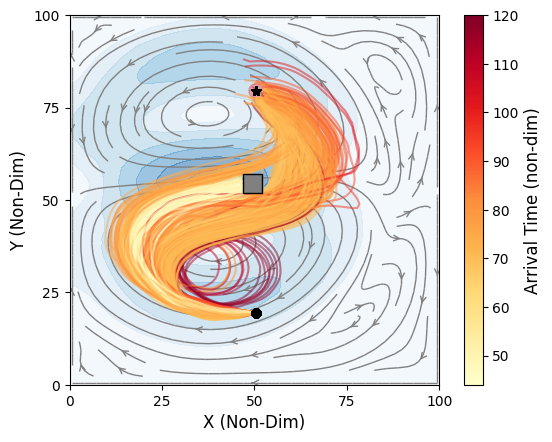

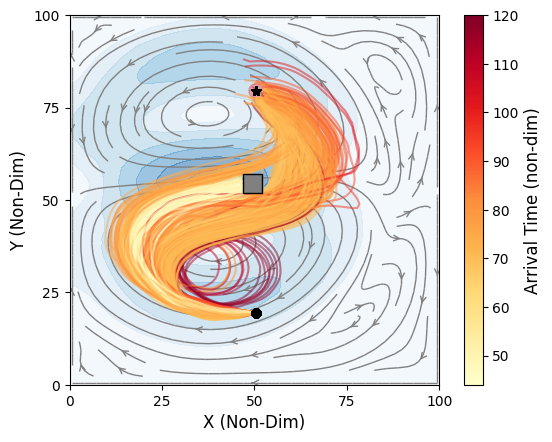

In [117]:
visualize_output(val_set_txy_preds, 
                    path_lens,
                    iter_i = 0, 
                    stats=None, 
                    env=env_4_viz, 
                    log_wandb=False, 
                    plot_policy=False,
                    traj_idx=None,      #None=all, list of rzn_ids []
                    show_scatter=False,
                    at_time=None,
                    color_by_time=True, #TODO: fix tdone issue in src_utils
                    plot_flow=True,
                    wandb_suffix="val",
                    model_name=f"Scenario_{scnerio_num}_all_baseline_maxsamples{max_samples}_",
                    alpha = 0.5,
                    obst_loc=obst_loc  # (x_ll, y_ll, w
                    ) 

path_lens = [89, 76, 70, 82, 71, 73, 70, 74, 76, 81, 71, 73, 71, 77, 71, 86, 70, 76, 75, 75, 73, 74, 111, 68, 77, 75, 88, 70, 68, 76, 73, 72, 71, 89, 71, 71, 70, 70, 73, 72, 111, 87, 71, 83, 73, 75, 72, 69, 70, 71, 77, 76, 74, 80, 72, 113, 77, 70, 69, 70, 70, 71, 72, 73, 70, 94, 71, 72, 72, 70, 72, 75, 73, 69, 75, 69, 81, 84, 74, 70, 88, 75, 70, 72, 112, 119, 85, 111, 71, 72, 74, 76, 70, 69, 72, 71, 70, 74, 74, 71, 74, 115, 76, 72, 79, 73, 94, 67, 72, 72, 68, 78, 69, 70, 71, 80, 78, 82, 78, 71, 73, 74, 71, 72, 71]
0
100


/tmp/ipykernel_2741603/2169634138.py:101: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(scalarMap, label="Arrival Time (non-dim)")


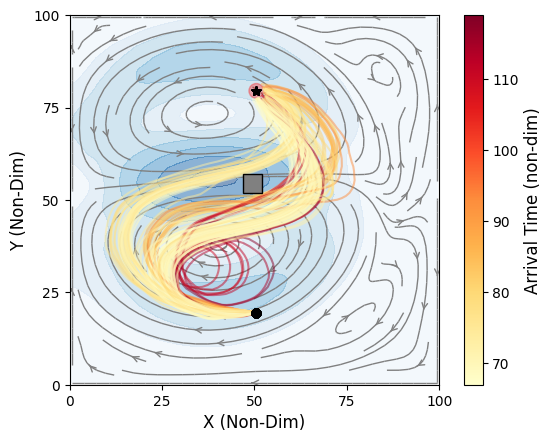

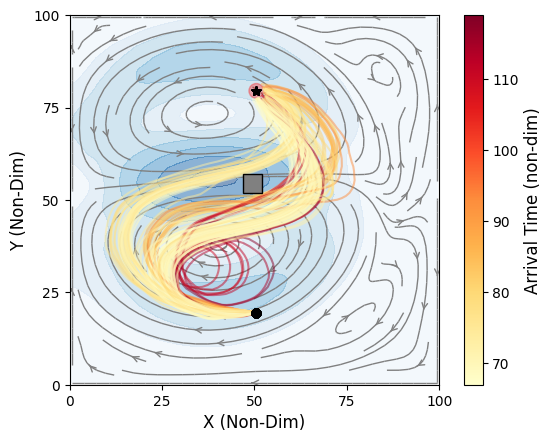

In [118]:
visualize_output(success_val_set_txy_preds, 
                    success_path_lens,
                    iter_i = 0, 
                    stats=None, 
                    env=env_4_viz, 
                    log_wandb=False, 
                    plot_policy=False,
                    traj_idx=None,      #None=all, list of rzn_ids []
                    show_scatter=False,
                    at_time=None,
                    color_by_time=True, #TODO: fix tdone issue in src_utils
                    plot_flow=True,
                    wandb_suffix="val",
                    model_name=f"Scenario_{scnerio_num}_success_baseline_maxsamples{max_samples}_",
                    alpha = 0.5,
                    obst_loc=obst_loc
                    ) 

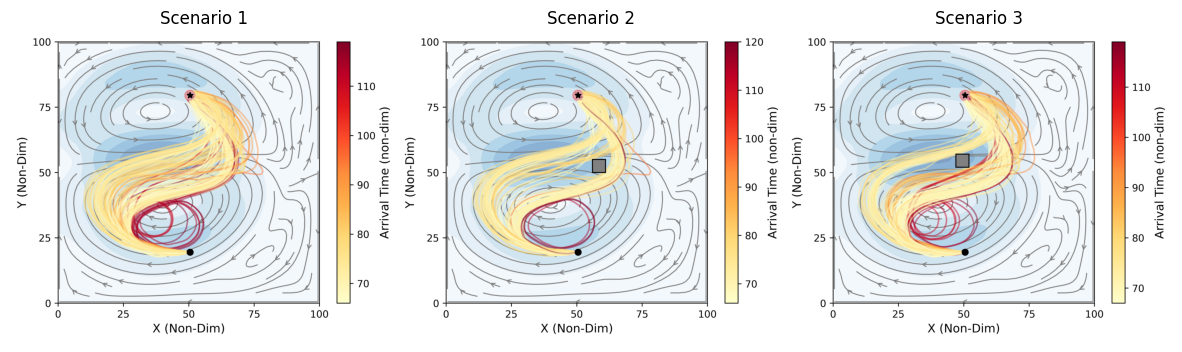

In [133]:
# load figure from file
# 'Translation_transformer/my-translat-transformer/tmp/last_exp_figs/Scenario_2_all_baseline_maxsamples500__pred_on_unseen.png'
plot_paths = [f'../tmp/last_exp_figs/Scenario_{i}_success_baseline_maxsamples500__pred_on_unseen.png' for i in [1,2,3]]
plots = [plt.imread(p) for p in plot_paths]

# plot with 3 subplots in a row
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (ax_i, plot_i) in enumerate(zip(ax, plots)):
    ax_i.set_aspect('equal', adjustable='box')
    ax_i.imshow(plot_i)
    ax_i.axis('off')
    ax_i.set_title(f'Scenario {i+1}')
    
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f'../tmp/last_exp_figs/combined_scenarios_success_baseline_maxsamples500__pred_on_unseen.png', dpi=600, bbox_inches='tight')